# 07 Comparing with the differential diagnosis datasets 

> Initial exploration of the data   

In [1]:
#|default_exp core.03b_explore_differential_datasets

In [2]:
#|hide
#import nbdev; nbdev.nbdev_export()

In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

import geopandas as gpd

--- 

### Import the font and style path foir the Autonomy *lewk*

In [6]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


This notebook looks at some analysis of the [Primary Care Dementia Data - December 2023](https://digital.nhs.uk/data-and-information/publications/statistical/primary-care-dementia-data/december-2023#summary), locally located here:

`dementia_inequalities/store/data/differential_diagnosis/pcdem-sicbl-dem-type-dec-2023.csv`

In [7]:
#|export 
df_icb_diff = pd.read_csv(const.data_path+'/differential_diagnosis/pcdem-sicbl-dem-type-dec-2023.csv')
df_young = pd.read_csv(const.data_path+ '/differential_diagnosis/pcdem-sicbl-incidence-onset-dec-2023.csv')

In [8]:
df_icb_diff.head()

,ACH_DATE,REGION_ODS_CODE,REGION_ONS_CODE,REGION_NAME,ICB_ODS_CODE,ICB_ONS_CODE,ICB_NAME,SUB_ICB_ODS_CODE,SUB_ICB_ONS_CODE,SUB_ICB_NAME,Measure,Value
0,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,ALZHEIMERS_DISEASE,5345.0
1,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,MIXED_DEMENTIA_TYPES,625.0
2,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,OTHER_DEMENTIA_TYPES,2690.0
3,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,VASCULAR_DEMENTIA,1940.0
4,31-Dec-23,Y56,E40000003,London,QMF,E54000029,NHS North East London Integrated Care Board,A3A8R,E38000255,NHS North East London ICB - A3A8R,ALZHEIMERS_DISEASE,3620.0


In [9]:
hist_df = df_icb_diff[df_icb_diff['Measure']=='ALZHEIMERS_DISEASE'][['ICB_NAME','Value']]

hist_df.columns = ['ICB', 'Alzheimers']

hist_df['Vascular'] = df_icb_diff[df_icb_diff['Measure']=='VASCULAR_DEMENTIA']['Value'].values
hist_df['Mixed'] = df_icb_diff[df_icb_diff['Measure']=='MIXED_DEMENTIA_TYPES']['Value'].values
hist_df['Other'] = df_icb_diff[df_icb_diff['Measure']=='OTHER_DEMENTIA_TYPES']['Value'].values

#hist_df.replace('*', '', inplace=True)
#hist_df[['Alzheimers', 'Vascular', 'Mixed', 'Other']].astype(float)

hist_df['Alzheimers'] = pd.to_numeric(hist_df['Alzheimers'], errors='coerce')
hist_df['Vascular'] = pd.to_numeric(hist_df['Vascular'], errors='coerce')
hist_df['Mixed'] = pd.to_numeric(hist_df['Mixed'], errors='coerce')
hist_df['Other'] = pd.to_numeric(hist_df['Other'], errors='coerce')

In [10]:
hist_df.head()

,ICB,Alzheimers,Vascular,Mixed,Other
0,NHS South East London Integrated Care Board,5345.0,1940.0,625.0,2690.0
4,NHS North East London Integrated Care Board,3620.0,1605.0,320.0,2690.0
8,NHS North Central London Integrated Care Board,4235.0,1225.0,230.0,2850.0
12,NHS North West London Integrated Care Board,5065.0,2040.0,335.0,5020.0
16,NHS South West London Integrated Care Board,5295.0,1620.0,390.0,3025.0


In [11]:
# reformat the ICB names 
unecessary_words = ['NHS', 'Integrated', 'Care', 'Board', 'ICB']
f = lambda x: ' '.join([item for item in x.split() if item not in unecessary_words])
hist_df['ICB'] = hist_df['ICB'].apply(f)

# group 
hist_df = hist_df.groupby('ICB')[['Alzheimers', 'Vascular', 'Mixed', 'Other']].sum()
hist_df.reset_index(inplace=True)

# add column with total dementia cases
hist_df['Total_dementia'] = hist_df[['Alzheimers', 'Vascular', 'Mixed', 'Other']].sum(axis=1)

# add column with percent of other cases
hist_df['pc_other'] = hist_df['Other']/hist_df['Total_dementia']

In [12]:
hist_df

,ICB,Alzheimers,Vascular,Mixed,Other,Total_dementia,pc_other
0,"Bath and North East Somerset, Swindon and Wilt...",27305.0,6970.0,4005.0,33865.0,72145.0,0.469402
1,"Bedfordshire, Luton and Milton Keynes",26965.0,6855.0,2445.0,28600.0,64865.0,0.440916
2,Birmingham and Solihull,32530.0,18520.0,3720.0,25320.0,80090.0,0.316144
3,Black Country,22650.0,20615.0,8150.0,33575.0,84990.0,0.395046
4,"Bristol, North Somerset and South Gloucestershire",25735.0,14515.0,4930.0,27830.0,73010.0,0.381181
5,"Buckinghamshire, Oxfordshire and Berkshire West",61780.0,16510.0,7420.0,41005.0,126715.0,0.323600
6,Cambridgeshire and Peterborough,27930.0,7335.0,2390.0,21165.0,58820.0,0.359827
7,Cheshire and Merseyside,95165.0,44650.0,13195.0,53335.0,206345.0,0.258475
8,Cornwall and the Isles of Scilly,18700.0,13700.0,2030.0,16925.0,51355.0,0.329569
9,Coventry and Warwickshire,26350.0,11230.0,5360.0,21085.0,64025.0,0.329324


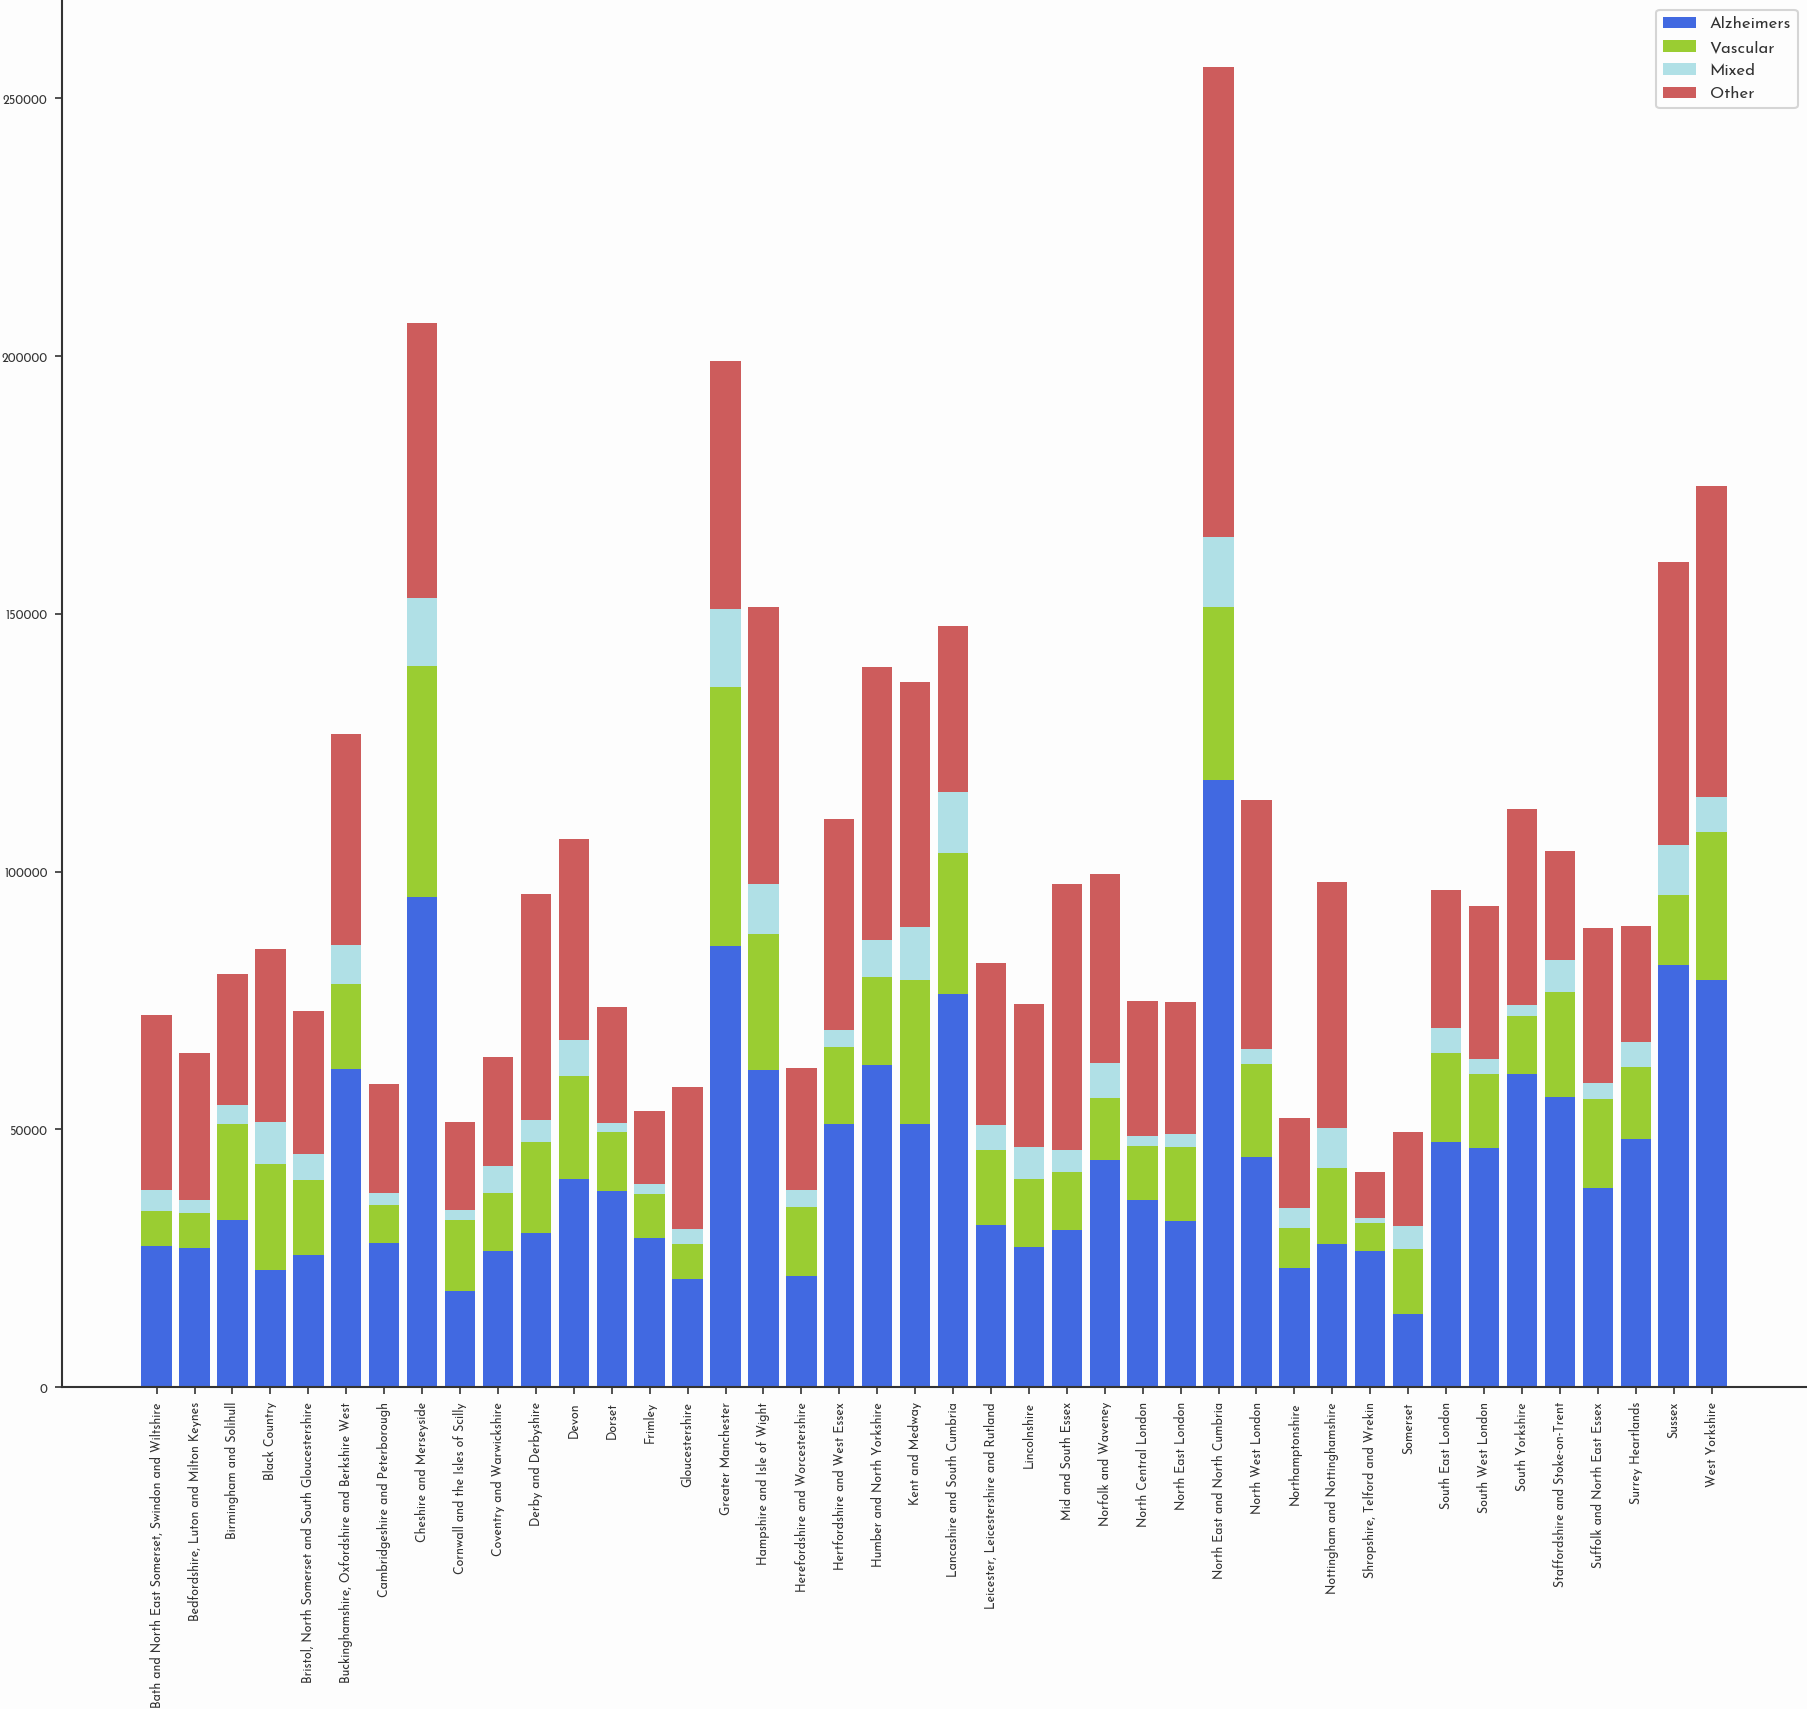

In [13]:
x =  hist_df['ICB'].values
y1 = hist_df['Alzheimers'].values
y2 = hist_df['Vascular'].values
y3 = hist_df['Mixed'].values
y4 = hist_df['Other'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1, color='royalblue')
plt.bar(x, y2, bottom=y1, color='yellowgreen')
plt.bar(x, y3, bottom=y1+y2, color='powderblue')
plt.bar(x, y4, bottom=y1+y2+y3, color='indianred')
plt.legend(['Alzheimers', 'Vascular', 'Mixed', 'Other'])
plt.xticks(rotation=90)
plt.show()

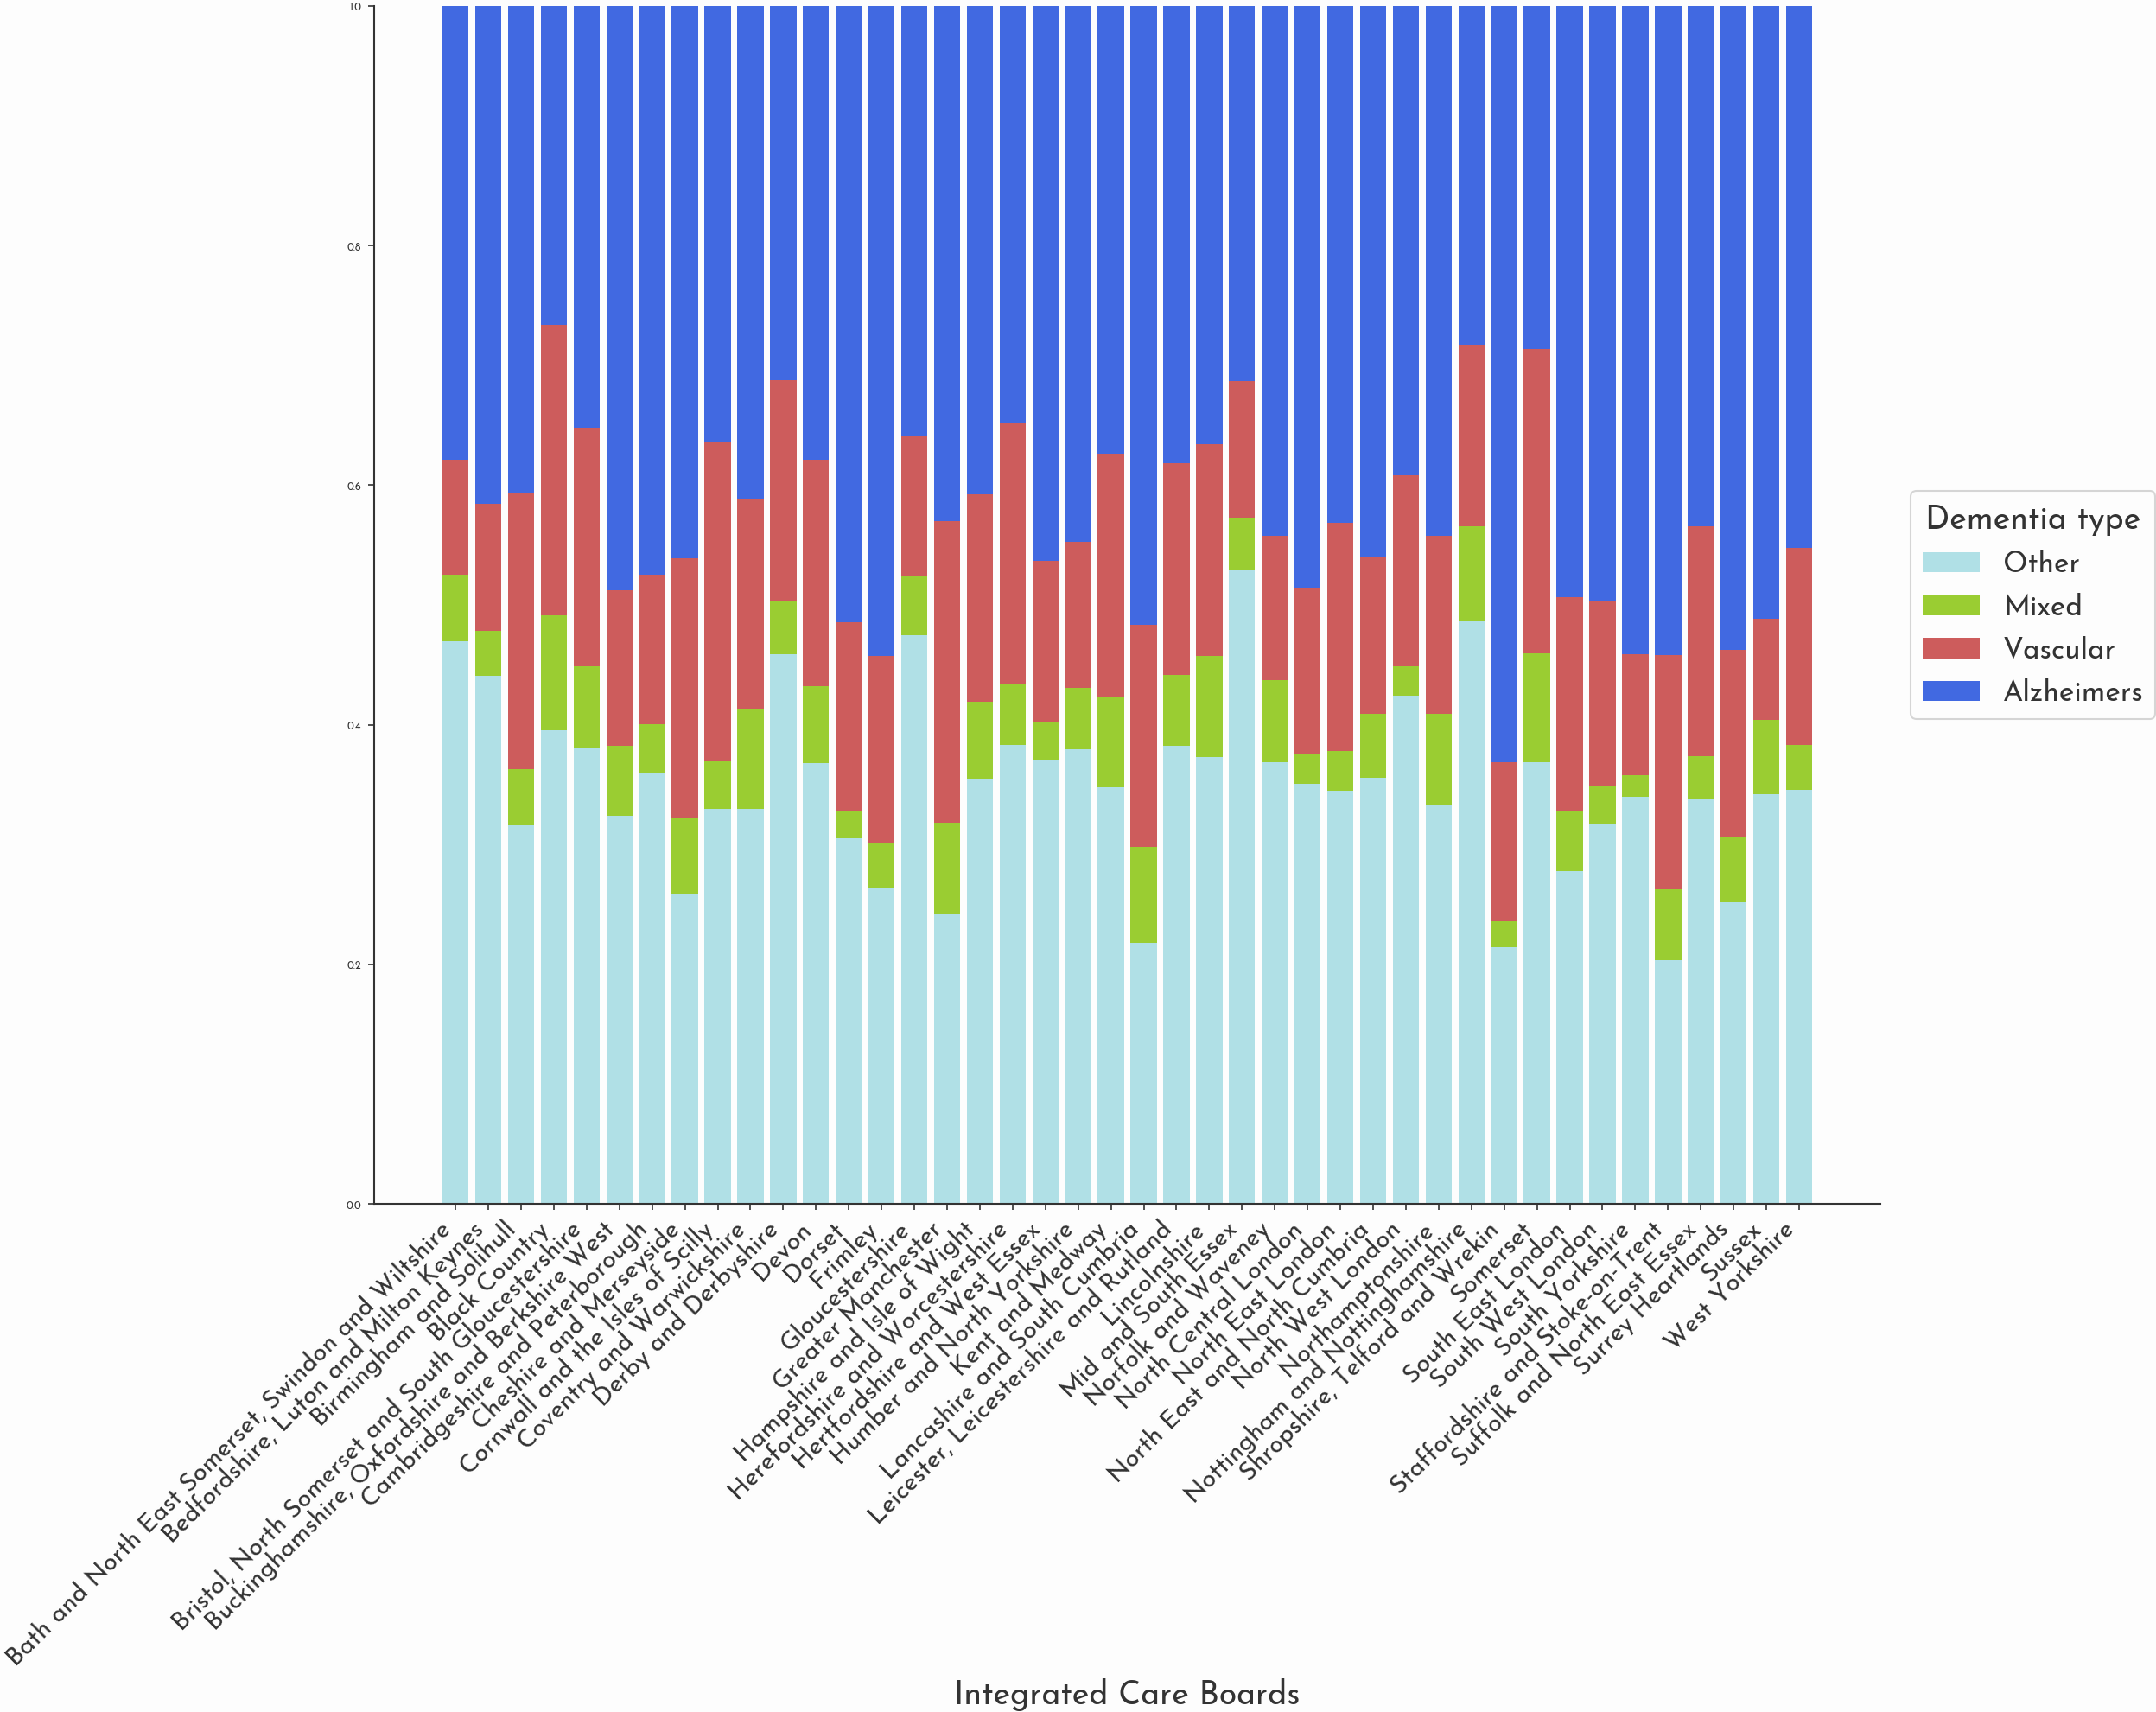

In [14]:
tot = hist_df['Total_dementia'].values
x =  hist_df['ICB'].values
y1 = hist_df['Other'].values
y2 = hist_df['Mixed'].values
y3 = hist_df['Vascular'].values
y4 = hist_df['Alzheimers'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1/tot, color='powderblue')
plt.bar(x, y2/tot, bottom=y1/tot, color='yellowgreen')
plt.bar(x, y3/tot, bottom=(y1+y2)/tot, color='indianred')
plt.bar(x, y4/tot, bottom=(y1+y2+y3)/tot, color='royalblue')
plt.legend(['Other', 'Mixed', 'Vascular', 'Alzheimers'],title='Dementia type', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.ylim(0,1)
plt.xlabel('Integrated Care Boards', fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

In [15]:
df_icb_young =  df_young[df_young['ORG_TYPE']=='ICB']

In [16]:
df_icb_young

,ACH_DATE,ORG_TYPE,ORG_CODE,ONS_CODE,NAME,Measure,Value
4,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",INCIDENCE,139
5,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",YOUNG_ONSET,477
6,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",DEMENTIA_REGISTER,8095
7,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",PAT_LIST_ALL,1003016
8,31-Dec-23,ICB,QHG,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Inte...",INCIDENCE,68
...,...,...,...,...,...,...,...
5159,30-Apr-23,ICB,QNX,E54000064,NHS Sussex ICB,PAT_LIST_ALL,1833806
5160,30-Apr-23,ICB,QWO,E54000054,NHS West Yorkshire Integrated Care Board,INCIDENCE,251
5161,30-Apr-23,ICB,QWO,E54000054,NHS West Yorkshire Integrated Care Board,YOUNG_ONSET,1647
5162,30-Apr-23,ICB,QWO,E54000054,NHS West Yorkshire Integrated Care Board,DEMENTIA_REGISTER,18869


In [17]:
young_hist_df = df_icb_young[df_icb_young['Measure']=='YOUNG_ONSET'][['NAME','Value']]

young_hist_df.columns = ['ICB', 'Young_onset']

young_hist_df['Total_patient_list'] = df_icb_young[df_icb_young['Measure']=='PAT_LIST_ALL']['Value'].values
young_hist_df['Total_dementia'] = df_icb_young[df_icb_young['Measure']=='DEMENTIA_REGISTER']['Value'].values

young_hist_df['Young_onset'] = pd.to_numeric(young_hist_df['Young_onset'], errors='coerce')
young_hist_df['Total_patient_list'] = pd.to_numeric(young_hist_df['Total_patient_list'], errors='coerce')
young_hist_df['Total_dementia'] = pd.to_numeric(young_hist_df['Total_dementia'], errors='coerce')

In [18]:
# reformat the ICB names 
young_hist_df['ICB'] = young_hist_df['ICB'].apply(f)

# group 
young_hist_df = young_hist_df.groupby('ICB')[['Young_onset', 'Total_patient_list', 'Total_dementia']].sum()
young_hist_df.reset_index(inplace=True)

In [19]:
young_hist_df

,ICB,Young_onset,Total_patient_list,Total_dementia
0,"Bath and North East Somerset, Swindon and Wilt...",4288,8945227,71284
1,"Bedfordshire, Luton and Milton Keynes",5799,10028344,64216
2,Birmingham and Solihull,6863,14432323,80279
3,Black Country,7333,11796397,84975
4,"Bristol, North Somerset and South Gloucestershire",4191,9703816,73365
5,"Buckinghamshire, Oxfordshire and Berkshire West",6131,17816609,127516
6,Cambridgeshire and Peterborough,4809,9274440,58171
7,Cheshire and Merseyside,14075,24804954,207326
8,Cornwall and the Isles of Scilly,2908,5361884,50985
9,Coventry and Warwickshire,4334,9793764,64824


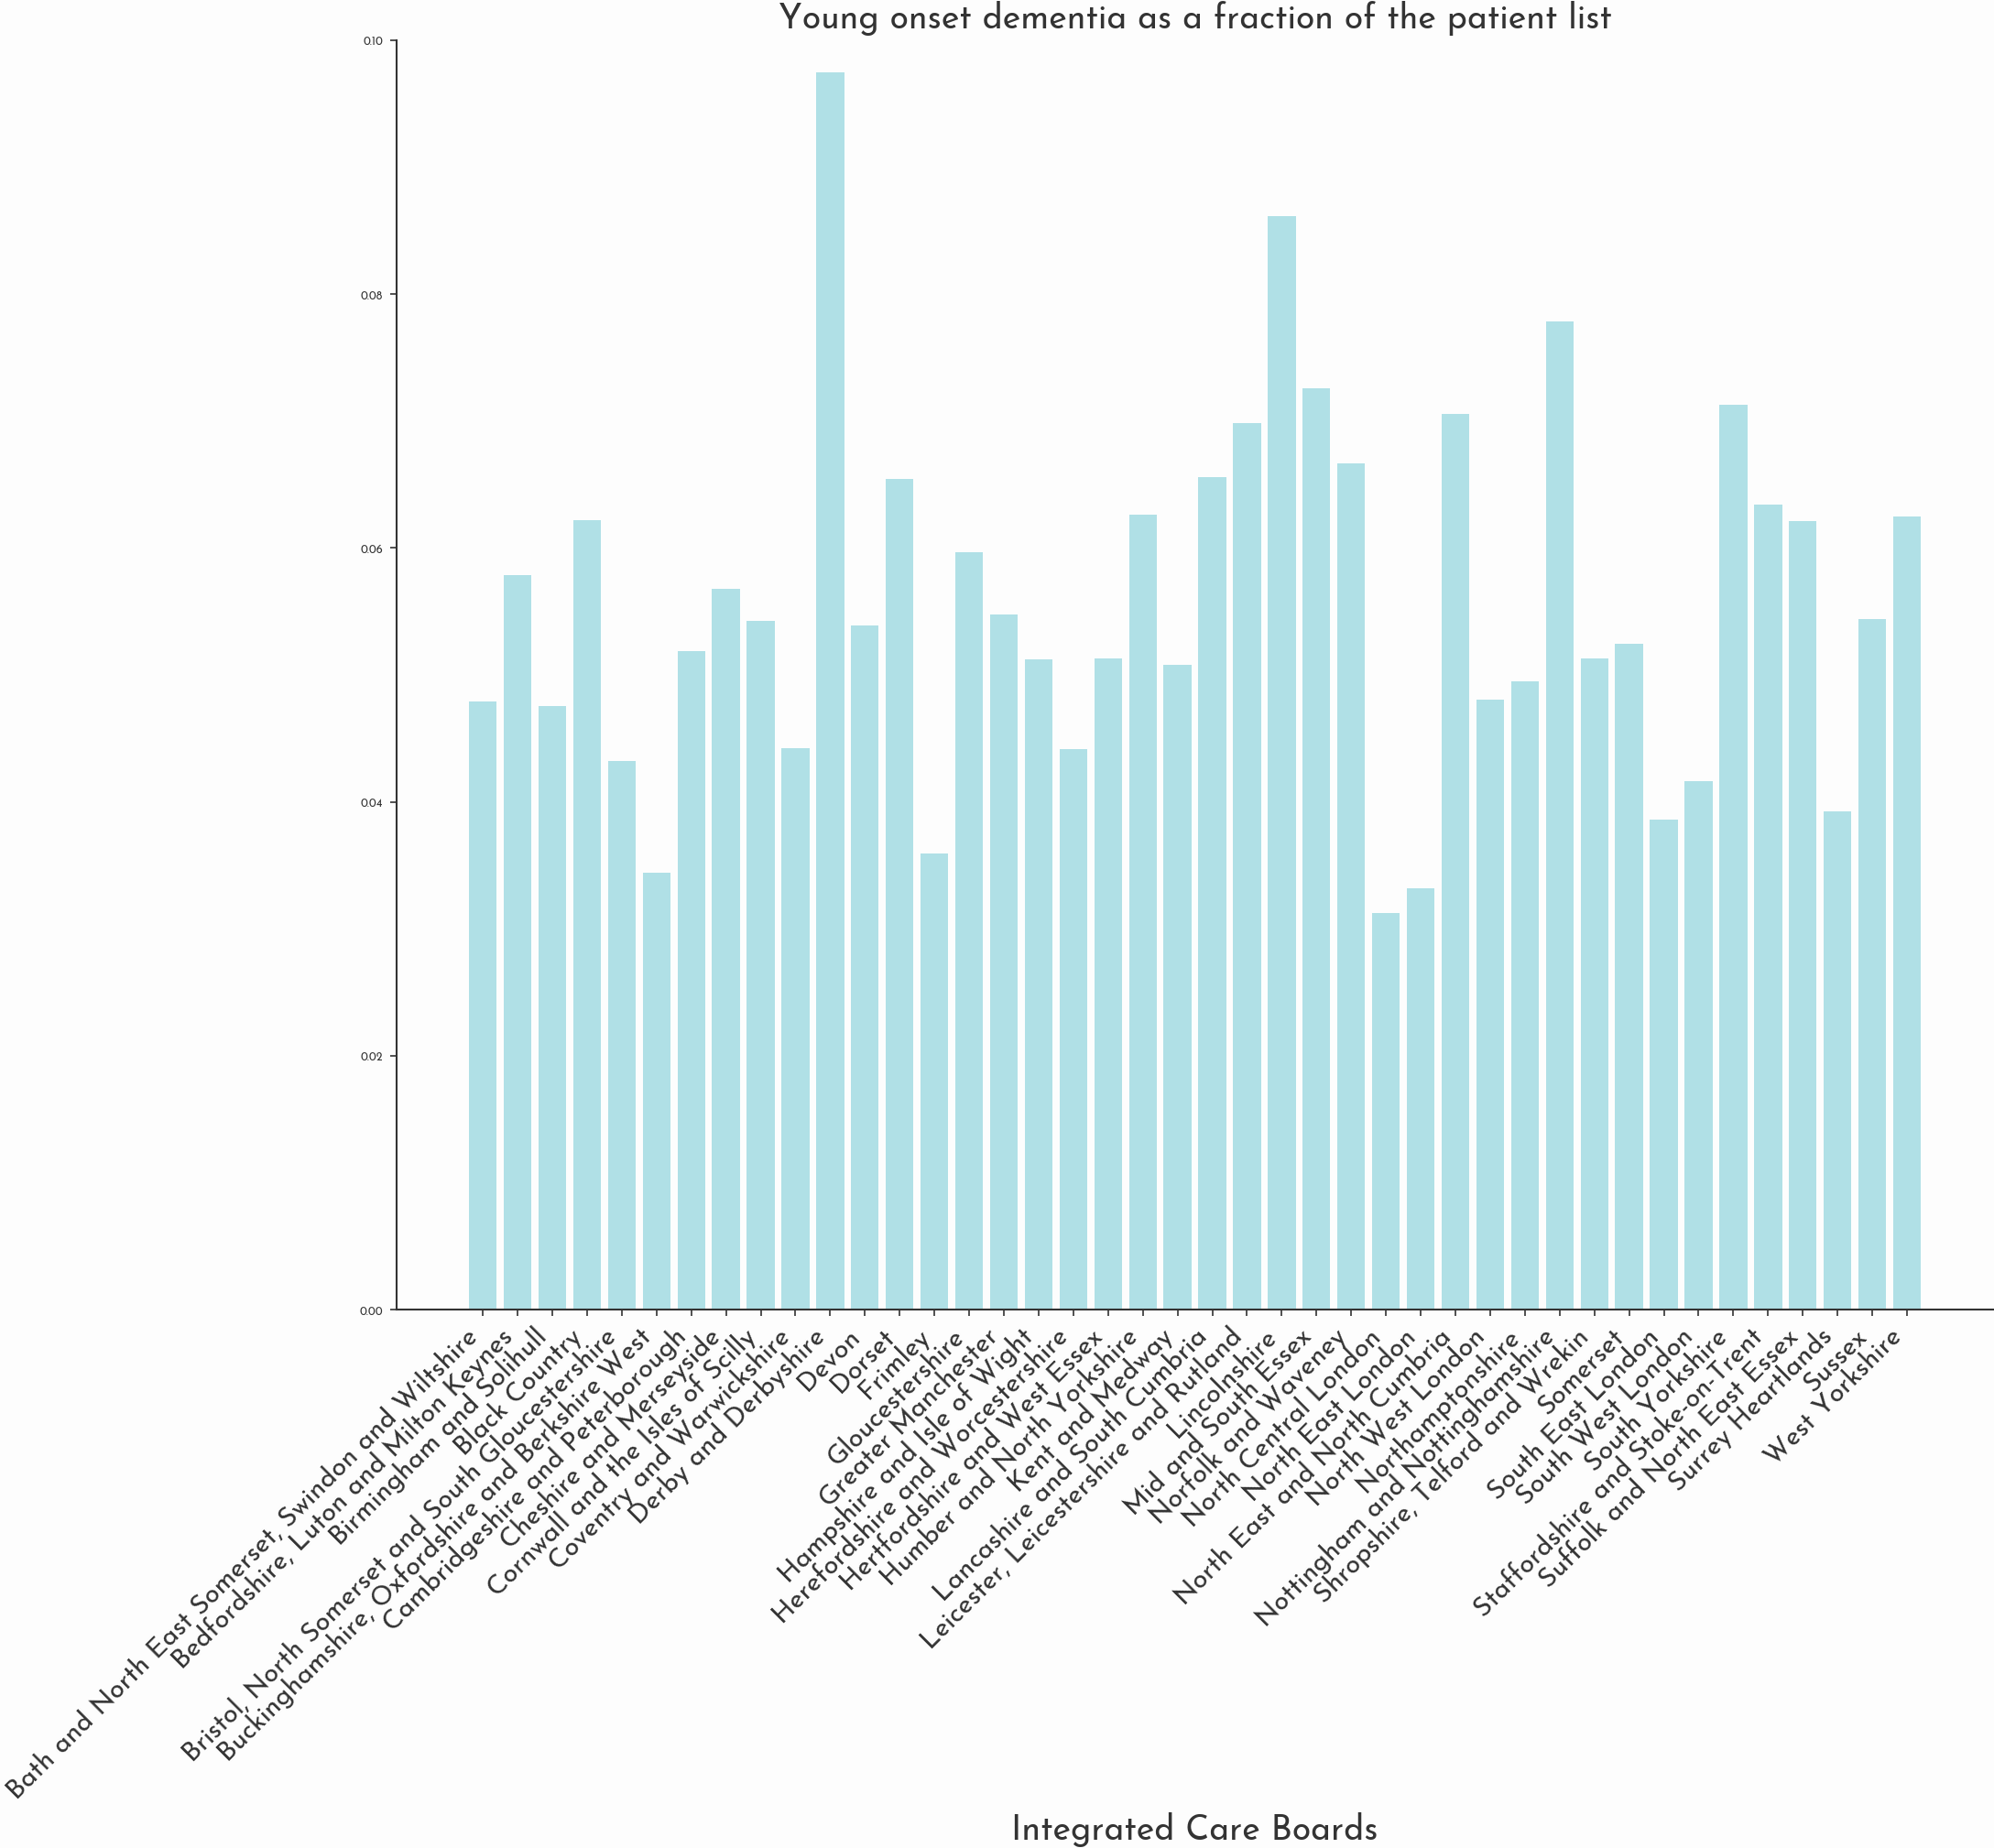

In [20]:
tot = young_hist_df['Total_patient_list'].values
x =  young_hist_df['ICB'].values
y1 = young_hist_df['Young_onset'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1/tot*100, color='powderblue')
plt.title('Young onset dementia as a fraction of the patient list', fontsize=18)
#plt.legend(['Young onset', 'All dementia'],title='Dementia type', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.ylim(0,0.1)
plt.xlabel('Integrated Care Boards', fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

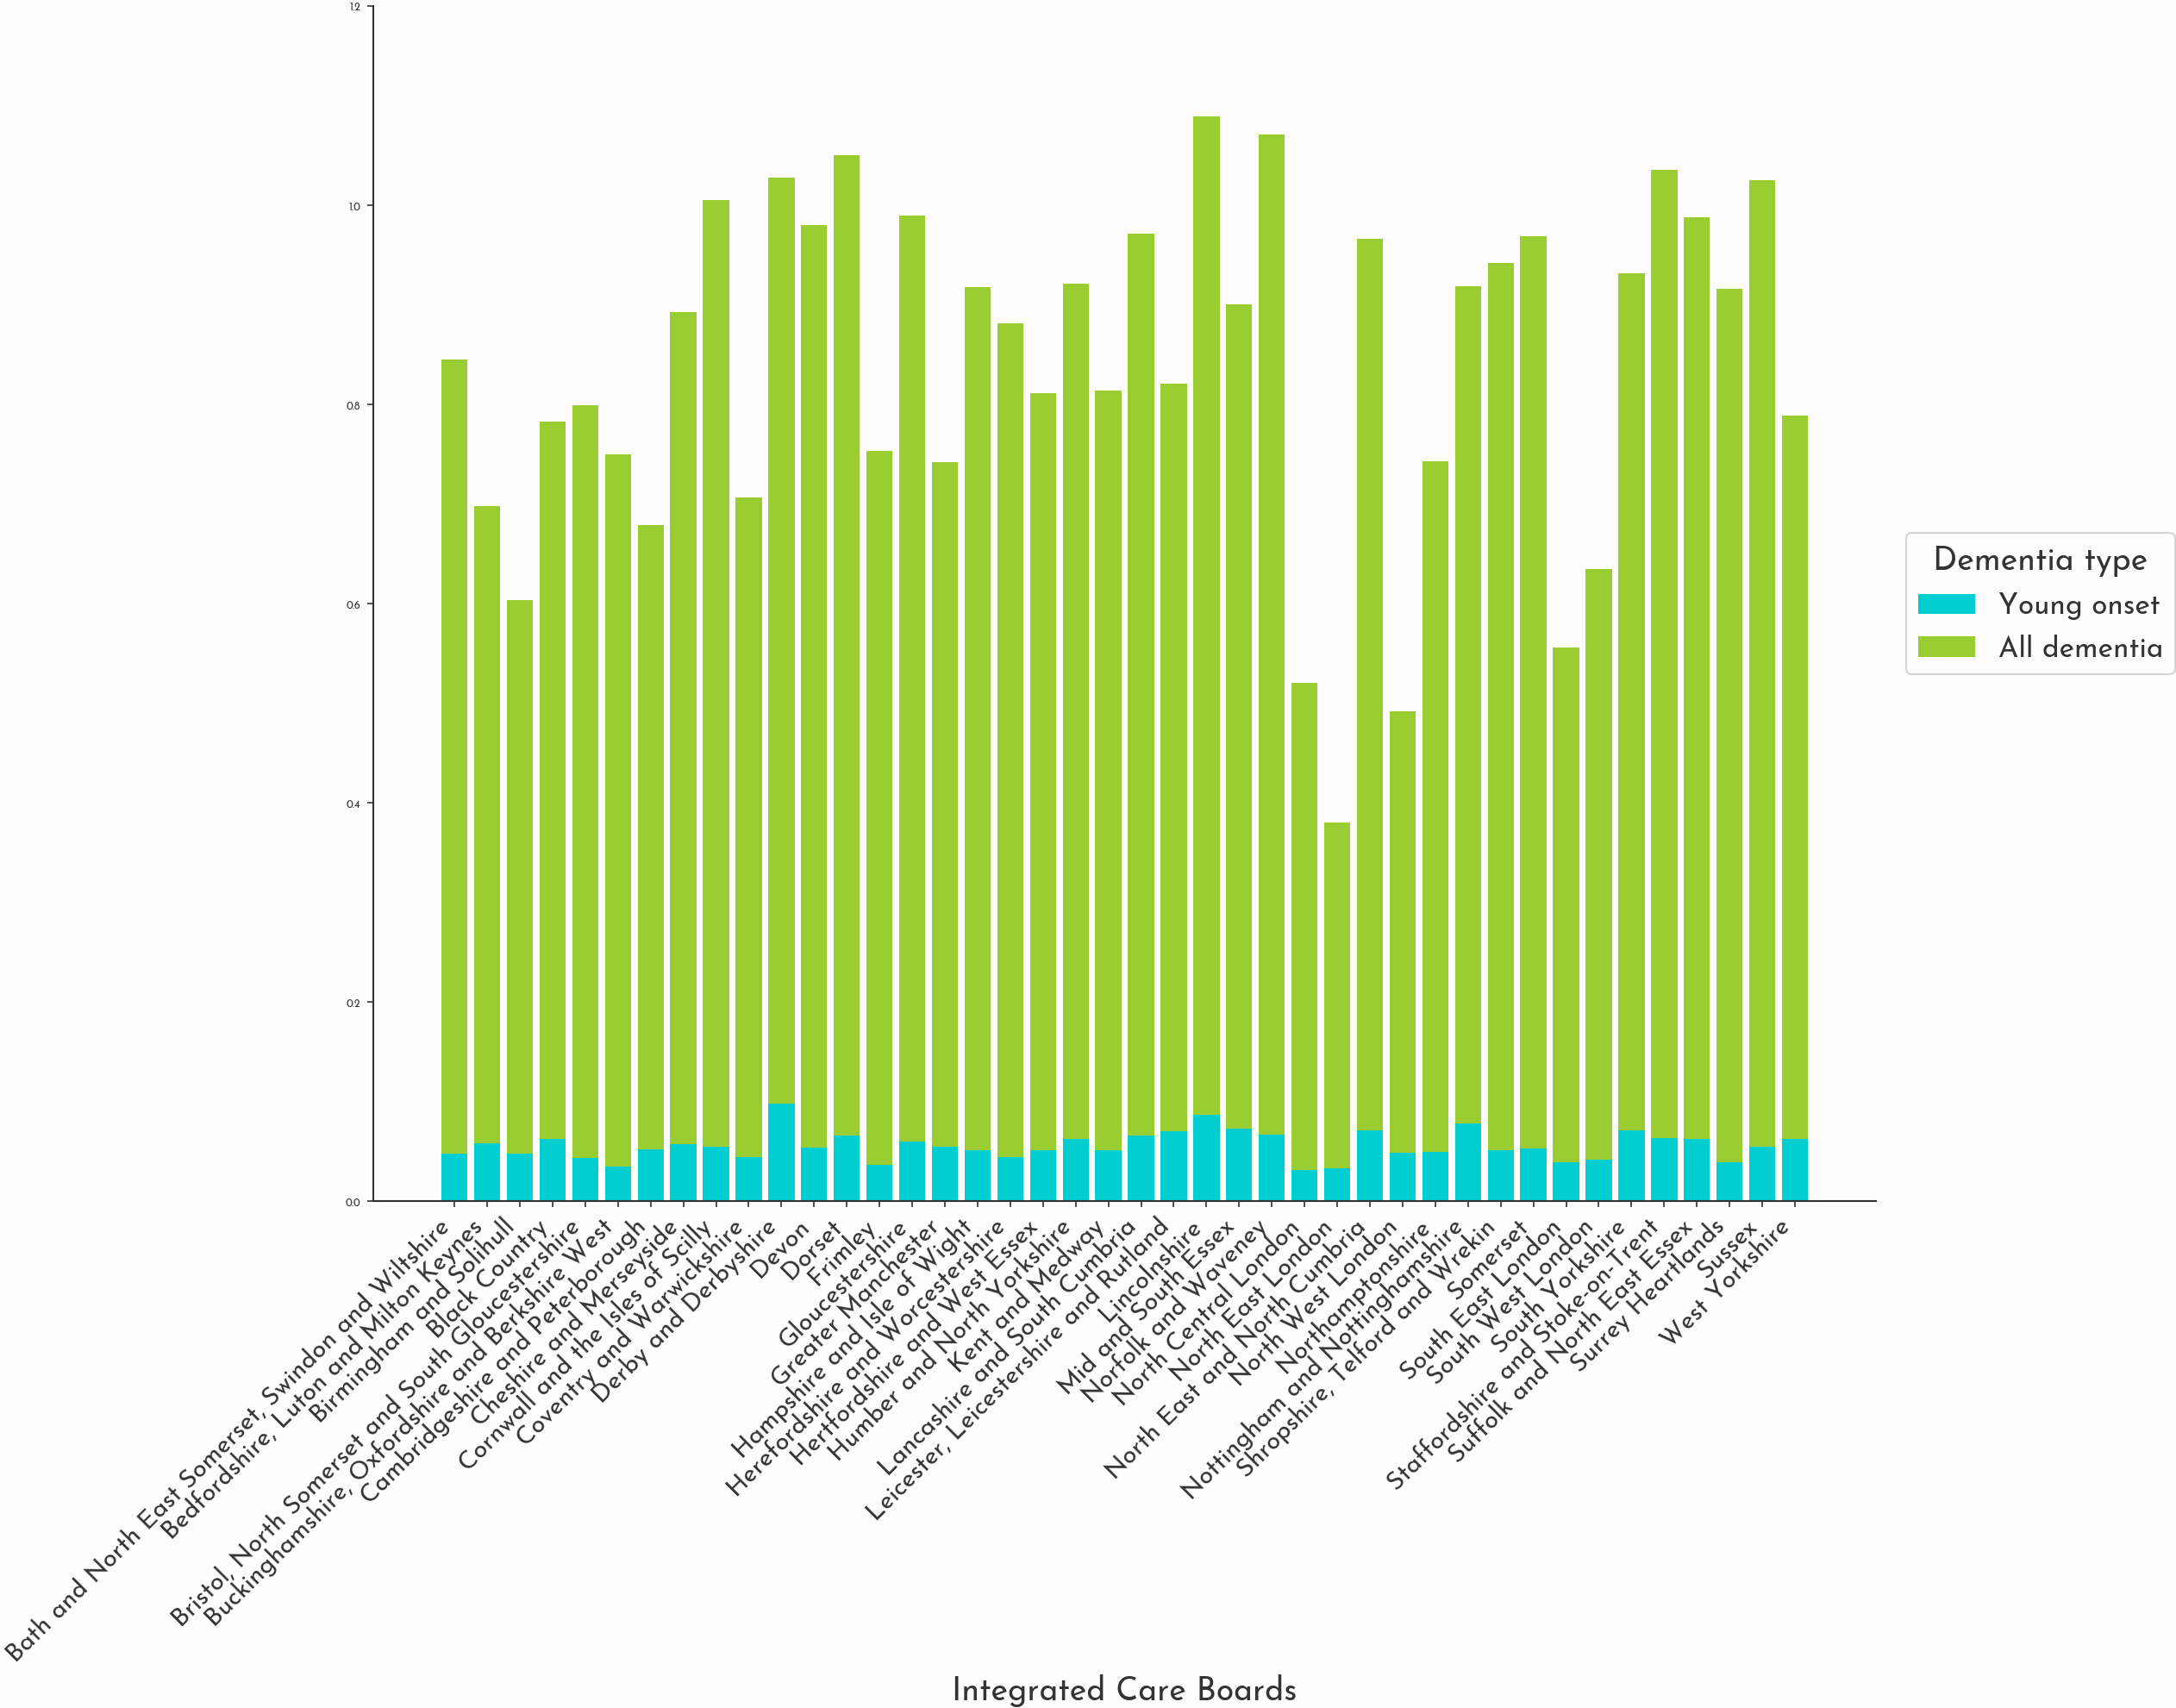

In [21]:
tot = young_hist_df['Total_patient_list'].values
x =  young_hist_df['ICB'].values
y1 = young_hist_df['Young_onset'].values
y2 = young_hist_df['Total_dementia'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1/tot*100, color='darkturquoise')
plt.bar(x, y2/tot*100, bottom=y1/tot*100, color='yellowgreen')
plt.legend(['Young onset', 'All dementia'],title='Dementia type', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.ylim(0,1.2)
plt.xlabel('Integrated Care Boards', fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

In [22]:
sICB_gpd = gpd.read_file(const.data_path+'/ICB_area/SICBL_JUL_2022_EN_BFE_1256329380810857931.geojson')

In [23]:
sICB_gpd

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,148fb5f5-ab50-444c-a494-6906ad125f1e,"POLYGON ((436701.906 413044.499, 436736.062 41..."
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,a0e23b23-3ab2-43b1-9b33-3f2f4e945425,"POLYGON ((561455.813 204293.859, 561470.000 20..."
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,caeb6781-58e8-4ad8-87bb-1baef293f1ad,"POLYGON ((472764.906 397877.000, 472708.563 39..."
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,369490,422806,-2.463600,53.70080,4,5b121fd3-7317-48e8-950a-951a1e8b99f9,"POLYGON ((369226.281 431801.188, 369234.000 43..."
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,332819,436634,-3.021990,53.82163,5,4293b1d6-23e4-4740-825b-c9dd58cd6448,"POLYGON ((332245.132 442555.113, 332245.431 44..."
...,...,...,...,...,...,...,...,...,...
101,E38000258,NHS Birmingham and Solihull ICB - 15E,412791,287491,-1.813060,52.48520,102,1c2b046b-d603-4918-a865-3570e5eb5b91,"POLYGON ((411959.594 301123.969, 412107.848 30..."
102,E38000259,NHS Black Country ICB - D2P2L,397406,292506,-2.039660,52.53043,103,9e0d8eb9-cad5-4b0b-9380-0c3549efb894,"POLYGON ((403466.084 306875.857, 403467.500 30..."
103,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,536856,268346,0.005437,52.29621,104,69b5c774-f2ac-48c8-8c36-d5034d2873d1,"POLYGON ((546699.439 317783.144, 546675.939 31..."
104,E38000261,NHS Derby and Derbyshire ICB - 15M,426752,353558,-1.602100,53.07860,105,c8c4bb94-10ec-4381-be20-0285238d4a2b,"POLYGON ((409407.594 404118.094, 409420.750 40..."


In [24]:
df_icb_diff

,ACH_DATE,REGION_ODS_CODE,REGION_ONS_CODE,REGION_NAME,ICB_ODS_CODE,ICB_ONS_CODE,ICB_NAME,SUB_ICB_ODS_CODE,SUB_ICB_ONS_CODE,SUB_ICB_NAME,Measure,Value
0,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,ALZHEIMERS_DISEASE,5345.0
1,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,MIXED_DEMENTIA_TYPES,625.0
2,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,OTHER_DEMENTIA_TYPES,2690.0
3,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,VASCULAR_DEMENTIA,1940.0
4,31-Dec-23,Y56,E40000003,London,QMF,E54000029,NHS North East London Integrated Care Board,A3A8R,E38000255,NHS North East London ICB - A3A8R,ALZHEIMERS_DISEASE,3620.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3811,30-Apr-23,Y63,E40000012,North East and Yorkshire,QWO,E54000054,NHS West Yorkshire Integrated Care Board,36J,E38000232,NHS West Yorkshire ICB - 36J,VASCULAR_DEMENTIA,625.0
3812,30-Apr-23,Y63,E40000012,North East and Yorkshire,QWO,E54000054,NHS West Yorkshire Integrated Care Board,X2C4Y,E38000254,NHS West Yorkshire ICB - X2C4Y,ALZHEIMERS_DISEASE,1765.0
3813,30-Apr-23,Y63,E40000012,North East and Yorkshire,QWO,E54000054,NHS West Yorkshire Integrated Care Board,X2C4Y,E38000254,NHS West Yorkshire ICB - X2C4Y,MIXED_DEMENTIA_TYPES,50.0
3814,30-Apr-23,Y63,E40000012,North East and Yorkshire,QWO,E54000054,NHS West Yorkshire Integrated Care Board,X2C4Y,E38000254,NHS West Yorkshire ICB - X2C4Y,OTHER_DEMENTIA_TYPES,1085.0


In [25]:
# create sub-IVB dataset 
df_sICB = df_icb_diff[df_icb_diff['Measure']=='ALZHEIMERS_DISEASE'][['ICB_NAME', 'SUB_ICB_ONS_CODE','SUB_ICB_NAME','Value']]

df_sICB.columns = ['ICB', 'SUB_ICB_ONS_CODE', 'SUB_ICB_NAME', 'Alzheimers']

df_sICB['Vascular'] = df_icb_diff[df_icb_diff['Measure']=='VASCULAR_DEMENTIA']['Value'].values
df_sICB['Mixed'] = df_icb_diff[df_icb_diff['Measure']=='MIXED_DEMENTIA_TYPES']['Value'].values
df_sICB['Other'] = df_icb_diff[df_icb_diff['Measure']=='OTHER_DEMENTIA_TYPES']['Value'].values

# Some weird values in the Mixed column
df_sICB['Mixed'] = df_sICB['Mixed'].str.replace('*', '0')

# force values to be floats 
df_sICB['Alzheimers'] = df_sICB['Alzheimers'].astype(float)
df_sICB['Vascular'] = df_sICB['Vascular'].astype(float)
df_sICB['Mixed'] = df_sICB['Mixed'].astype(float)
df_sICB['Other'] = df_sICB['Other'].astype(float)

# format the dataframe 
df_sICB = df_sICB.groupby('SUB_ICB_ONS_CODE')[['Alzheimers', 'Vascular', 'Mixed', 'Other']].sum()
df_sICB.reset_index(inplace=True)

# Total case count 
df_sICB['Total'] = df_sICB[['Alzheimers', 'Vascular', 'Mixed', 'Other']].sum(axis=1)

# replace the incorrect codes 
df_sICB['SUB_ICB_ONS_CODE'] = df_sICB['SUB_ICB_ONS_CODE'].str.replace('E38000264', 'E38000246')
df_sICB['SUB_ICB_ONS_CODE'] = df_sICB['SUB_ICB_ONS_CODE'].str.replace('E38000265', 'E38000248')

df_sICB['Other_pc'] = 100*df_sICB['Other']/df_sICB['Total']

In [26]:
sICB_diagnosis = pd.merge(sICB_gpd, df_sICB, left_on='SICBL22CD', right_on='SUB_ICB_ONS_CODE')

In [28]:
sICB_diagnosis

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry,SUB_ICB_ONS_CODE,Alzheimers,Vascular,Mixed,Other,Total,Other_pc
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,148fb5f5-ab50-444c-a494-6906ad125f1e,"POLYGON ((436701.906 413044.499, 436736.062 41...",E38000006,12980.0,2150.0,320.0,4890.0,20340.0,24.041298
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,a0e23b23-3ab2-43b1-9b33-3f2f4e945425,"POLYGON ((561455.813 204293.859, 561470.000 20...",E38000007,6690.0,1855.0,520.0,9335.0,18400.0,50.733696
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,caeb6781-58e8-4ad8-87bb-1baef293f1ad,"POLYGON ((472764.906 397877.000, 472708.563 39...",E38000008,3695.0,2130.0,1180.0,5890.0,12895.0,45.676619
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,369490,422806,-2.463600,53.70080,4,5b121fd3-7317-48e8-950a-951a1e8b99f9,"POLYGON ((369226.281 431801.188, 369234.000 43...",E38000014,5155.0,1830.0,850.0,2265.0,10100.0,22.425743
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,332819,436634,-3.021990,53.82163,5,4293b1d6-23e4-4740-825b-c9dd58cd6448,"POLYGON ((332245.132 442555.113, 332245.431 44...",E38000015,6125.0,2730.0,1150.0,3865.0,13870.0,27.865898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,E38000258,NHS Birmingham and Solihull ICB - 15E,412791,287491,-1.813060,52.48520,102,1c2b046b-d603-4918-a865-3570e5eb5b91,"POLYGON ((411959.594 301123.969, 412107.848 30...",E38000258,32530.0,18520.0,3720.0,25320.0,80090.0,31.614434
102,E38000259,NHS Black Country ICB - D2P2L,397406,292506,-2.039660,52.53043,103,9e0d8eb9-cad5-4b0b-9380-0c3549efb894,"POLYGON ((403466.084 306875.857, 403467.500 30...",E38000259,22650.0,20615.0,8150.0,33575.0,84990.0,39.504648
103,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,536856,268346,0.005437,52.29621,104,69b5c774-f2ac-48c8-8c36-d5034d2873d1,"POLYGON ((546699.439 317783.144, 546675.939 31...",E38000260,27930.0,7335.0,2390.0,21165.0,58820.0,35.982659
104,E38000261,NHS Derby and Derbyshire ICB - 15M,426752,353558,-1.602100,53.07860,105,c8c4bb94-10ec-4381-be20-0285238d4a2b,"POLYGON ((409407.594 404118.094, 409420.750 40...",E38000261,29890.0,17650.0,4290.0,43890.0,95720.0,45.852486


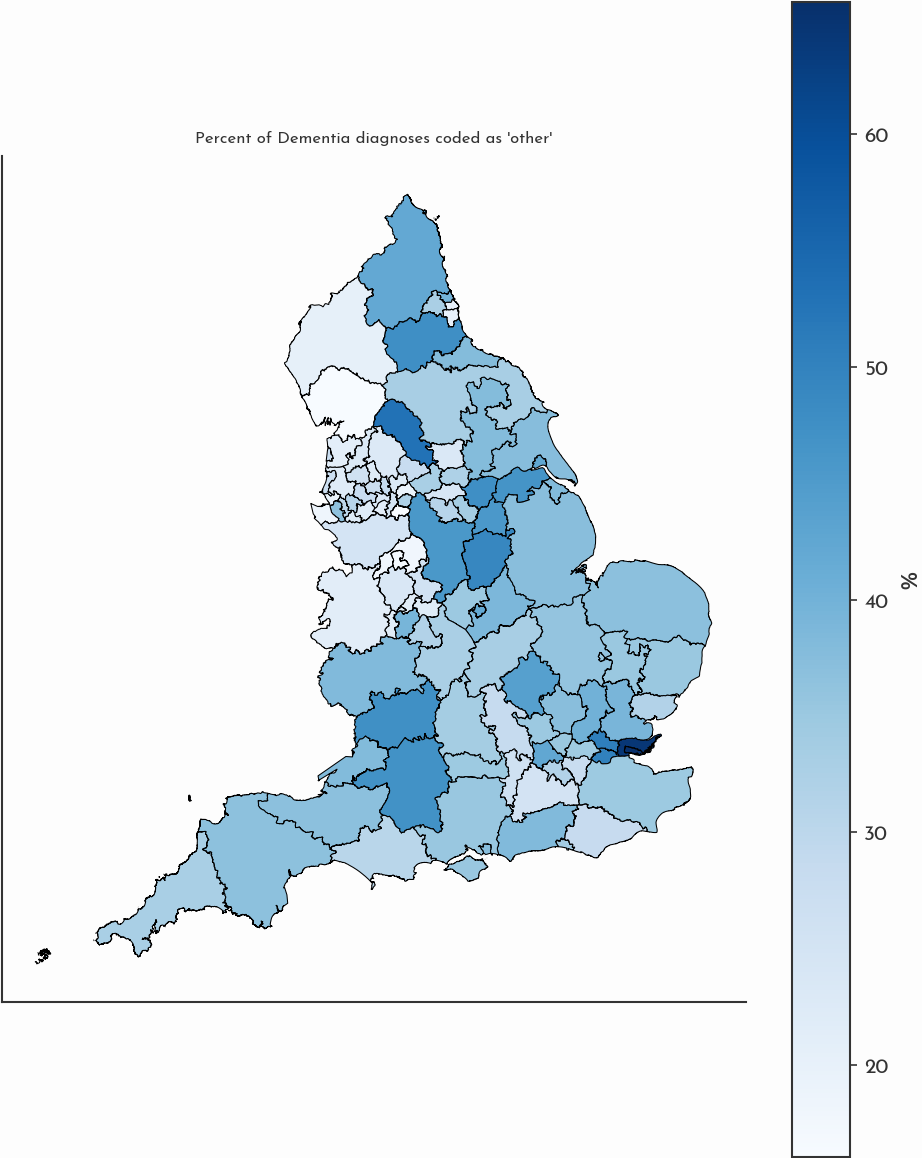

In [27]:
fig, ax = plt.subplots(figsize=(8,10))
sICB_diagnosis.plot(ax=ax, column='Other_pc', edgecolor='black', linewidth=0.5, alpha=1.0, cmap='Blues', legend=True)
#ax.set_axis_off()
plt.xticks([])
plt.yticks([])
plt.title("Percent of Dementia diagnoses coded as 'other'")
cb_ax = ax.figure.axes[1]
cb_ax.set_ylabel('%', size=12)
cb_ax.tick_params(labelsize=10)
plt.yticks([])
plt.xticks([])
plt.show()

In [29]:
sICB_diagnosis[sICB_diagnosis['Other_pc']>=50]['SICBL22NM'].values

array(['NHS Mid and South Essex ICB - 99E',
       'NHS Mid and South Essex ICB - 99F',
       'NHS Mid and South Essex ICB - 99G',
       'NHS Mid and South Essex ICB - 07G',
       'NHS West Yorkshire ICB - 36J'], dtype=object)

We can load the lookup table between ICB - sub-ICB - LSOA and LAD. This comes from data.gov.uk [here](https://www.data.gov.uk/dataset/18f418f5-878c-465a-899a-2a3b09374c32/lsoa-2011-to-sub-icb-locations-to-integrated-care-boards-july-2022-lookup-in-england). 

In [139]:
lookup = pd.read_csv(const.data_path+'/ICB_LSOA_LAD_lookup/LSOA_(2011)_to_Sub_ICB_Locations_to_Integrated_Care_Boards_(July_2022)_Lookup_in_England.csv')

In [32]:
lookup.head()

,LSOA11CD,LSOA11NM,SICBL22CD,SICBL22CDH,SICBL22NM,ICB22CD,ICB22CDH,ICB22NM,LAD22CD,LAD22NM,ObjectId
0,E01012367,Halton 007A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton,1
1,E01012368,Halton 003A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton,2
2,E01012369,Halton 005A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton,3
3,E01012370,Halton 007B,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton,4
4,E01012371,Halton 016A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton,5


In [33]:
lookup[lookup['LAD22NM']=='South Hams']['SICBL22NM'].unique()

array(['NHS Devon ICB - 15N'], dtype=object)